In [1]:
#Para la limpieza y tratamiento de datos
import pandas as pd
import numpy as np

#Efectos visuales
 # para poder visualizar todas las columnas de los DataFrames
pd.set_option('display.max_columns', None)
 # Ignorar warings
import warnings
warnings.filterwarnings("ignore")

#Gestionar contraseñas
import os
import dotenv
from dotenv import load_dotenv
load_dotenv()

#Interactuar con postgresql
import psycopg2
from psycopg2 import sql

#Importar funciones
import sys 
sys.path.append(os.path.abspath("../src"))   
import funciones as f

#Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

#AB_testing
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest


## EDA  

  
**NULOS:**  
No hay ningún valor nulo  


**DUPLICADOS:**  
- No hay duplicados porque cada fila corresponde a un usuario distinto  
  

**DATOS DE INTERES:**  
Hay un total de 824 usuarios.  
- La media de la duración del contenido está 167 minutos por encima de la mediana lo que nos indica que hay contenidos con una alta duración que nos distorsiona la media. Además observamos una gran desviación estándar (592 minutos) lo que implica duraciones muy variables por ejemplo el mínimo con 22 minutos y el máximo con 5873 minutos.Esto se explica porque es la suma de la duración de todo el contenido consumido por el usuario.    

- La media de contenidos vistos está en torno a 7 contenidos mientras que la mediana se encuentra en 6. De nuevo, se observa bastante desviación (5,88) con un mínimo de contenido de 1 y un máximos de 49 contenidos. Algo peculiar, es que estas estadísticas coinciden exactaente con el número de interacciones del usuario con el contenido.  

- Los estadísticos principales de los minutos vistos guardan bastante similitud con los mencionados en la duracón del contenido. Aunque eso si, cuenta con un mínimo de 2 minutos y un máximo de 4515 minutos vistos.  

- En cuanto a la cantidad de categorías de contenido, se observa que la media es de 2 categorías lo que se alinea con la mediana de 2. Esto indica que la mayoría de usuarios disfrutan de entorno a 2 categorias en lugar de solo 1 o las 5 (min y max).  


- En cuanto a la tasa de repetición, nos percatamos de como la media es de 0,57 lo que no se encuentra muy alejado de la mediana mostrando así como hay en mayor o menor medida, un equilibrio entre gente que repite su contenido y gente que no.  
  

- Vemos también un ajuste casi perfecto entre media y mediana de la valoración media que ronda las 3 estrellas.  


En otros datos de interés, los valores más repetidos en algunas columnas son:  
- la combinación de serie y short, la interacción en la que unicamente se añade a favoritos (97 veces) y vemos una ligera frecuencia mayor en no terminar el contenido.  



***OBSERVACIONES:***  
  
- Me he dado cuenta de que los minutos visualizados a veces son mayores a la duración del propio contenido (He calculado una nueva columna que refleja si se terminó ono de visuzalizar el contenido)  

- Me he dado cuenta de que alguno id_usuario faltaban en la base de datos por ejemplo el 9,15 y 23  

- Los tamaños muestrales de reomendeito y recomendeitor plus no coinciden (432 y 392 respectivamente (52,43% y 42,57%)) lo que se tendrá que tener en cuenta en algunos test  

In [2]:
key= os.getenv("key")

In [3]:
conexion=f.iniciar_conexion("localhost","postgres",key,5432,"Streaming_proyect")

In [4]:
cursor=conexion.cursor()
query_df=""" 
SELECT u.id AS id_usuario, user_type AS tipo_usuario, u.recommendation_system AS recomendacion_usuario,c.id AS id_contenido,c.duration AS duracion_contenido,c.content_type AS tipo_contenido,c.rating AS valoracion_contenido,v.id AS id_views, v.user_id AS id_usuario_views, v.content_id AS id_contenido_views, duration_viewed AS minutos_vistos , v.recommendation_system AS recomendacion_views,ui.id AS id_interaccion,ui.user_id AS id_usuario_interaccion,ui.content_id AS id_contenido_interaccion,ui.interaction_type AS tipo_interaccion 
FROM users u 
INNER JOIN "views" v ON u.id = v.user_id 
INNER JOIN user_interactions ui ON u.id = ui.user_id 
INNER JOIN "content" c ON c.id = v.content_id;

"""
lista_encabezados=['id_usuario', 'tipo_usuario', 'recomendacion_usuario', 'id_contenido', 'duracion_contenido', 'tipo_contenido', 
 'valoracion_contenido', 'numero_views', 'id_usuario_views', 'id_contenido_views', 'minutos_vistos', 
 'recomendacion_views', 'numero_interaccion', 'id_usuario_interaccion', 'id_contenido_interaccion', 'tipo_interaccion']


cursor.execute(query_df)   
df=pd.DataFrame(cursor.fetchall(), columns= lista_encabezados)


Me he dado cuenta de que los minutos visualizados a veces son mayores que la duración del propio contenido

In [5]:
df[df["id_usuario"]== 2]

,id_usuario,tipo_usuario,recomendacion_usuario,id_contenido,duracion_contenido,tipo_contenido,valoracion_contenido,numero_views,id_usuario_views,id_contenido_views,minutos_vistos,recomendacion_views,numero_interaccion,id_usuario_interaccion,id_contenido_interaccion,tipo_interaccion
1887,2,moderator,Recomendeitor,102,23,documentary,2.2,949,2,102,129,Recomendeitor,235,2,19,share


In [6]:
df.head()

,id_usuario,tipo_usuario,recomendacion_usuario,id_contenido,duracion_contenido,tipo_contenido,valoracion_contenido,numero_views,id_usuario_views,id_contenido_views,minutos_vistos,recomendacion_views,numero_interaccion,id_usuario_interaccion,id_contenido_interaccion,tipo_interaccion
0,214,moderator,Recomendeitor_Plus,153,92,movie,2.5,1,214,153,107,Recomendeitor,1787,214,167,favorite
1,214,moderator,Recomendeitor_Plus,153,92,movie,2.5,1,214,153,107,Recomendeitor,1271,214,180,share
2,214,moderator,Recomendeitor_Plus,153,92,movie,2.5,1,214,153,107,Recomendeitor,1112,214,21,favorite
3,214,moderator,Recomendeitor_Plus,153,92,movie,2.5,1,214,153,107,Recomendeitor,559,214,91,like
4,214,moderator,Recomendeitor_Plus,153,92,movie,2.5,1,214,153,107,Recomendeitor,446,214,80,favorite


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6013 entries, 0 to 6012
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id_usuario                6013 non-null   int64 
 1   tipo_usuario              6013 non-null   object
 2   recomendacion_usuario     6013 non-null   object
 3   id_contenido              6013 non-null   int64 
 4   duracion_contenido        6013 non-null   int64 
 5   tipo_contenido            6013 non-null   object
 6   valoracion_contenido      6013 non-null   object
 7   numero_views              6013 non-null   int64 
 8   id_usuario_views          6013 non-null   int64 
 9   id_contenido_views        6013 non-null   int64 
 10  minutos_vistos            6013 non-null   int64 
 11  recomendacion_views       6013 non-null   object
 12  numero_interaccion        6013 non-null   int64 
 13  id_usuario_interaccion    6013 non-null   int64 
 14  id_contenido_interaccion

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id_usuario,6013.0,510.898054,287.277034,1.0,256.0,503.0,767.0,999.0
id_contenido,6013.0,100.245136,57.396154,1.0,52.0,100.0,150.0,200.0
duracion_contenido,6013.0,93.209546,50.445804,10.0,46.0,91.0,139.0,178.0
numero_views,6013.0,1482.385831,859.185107,1.0,735.0,1489.0,2217.0,2998.0
id_usuario_views,6013.0,510.898054,287.277034,1.0,256.0,503.0,767.0,999.0
id_contenido_views,6013.0,100.245136,57.396154,1.0,52.0,100.0,150.0,200.0
minutos_vistos,6013.0,87.421088,51.344747,1.0,43.0,85.0,131.0,179.0
numero_interaccion,6013.0,1010.408282,573.870375,1.0,517.0,1015.0,1514.0,2000.0
id_usuario_interaccion,6013.0,510.898054,287.277034,1.0,256.0,503.0,767.0,999.0
id_contenido_interaccion,6013.0,98.859970,57.819729,1.0,49.0,98.0,148.0,200.0


In [9]:
df.describe(include="O").T

,count,unique,top,freq
tipo_usuario,6013,4,content_creator,1565
recomendacion_usuario,6013,2,Recomendeitor,3075
tipo_contenido,6013,5,short,1362
valoracion_contenido,6013,41,3.9,297
recomendacion_views,6013,2,Recomendeitor_Plus,3083
tipo_interaccion,6013,4,favorite,1603


In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
# df.groupby("id_usuario")[["minutos_vistos","duracion_contenido"]].sum()

In [12]:


#agrupo por id usuario y aplico funciones de agregación al resto porque nos obliga (aunque tenga que pasar a lista( meto set porque así no se pueden repetir valores))
df_usuarios = df.groupby("id_usuario").agg({      #asi puedo aplicar funciones de agregacion a todo junto sin tener que hacerlo por separado
    'tipo_usuario': 'first',  
    'recomendacion_usuario': 'first',  
    'id_contenido': lambda x: list(set(x)),  
    'duracion_contenido': 'sum',  
    'tipo_contenido': lambda x: list(set(x)),  
    'valoracion_contenido': lambda x: list(set(x)),  
    'numero_views': 'count',  
    'minutos_vistos': 'sum',  
    'recomendacion_views':'first',  
    'numero_interaccion': 'count',  
    'tipo_interaccion': lambda x: list(set(x))  
}).reset_index()




In [13]:
df_usuarios.head(5)

,id_usuario,tipo_usuario,recomendacion_usuario,id_contenido,duracion_contenido,tipo_contenido,valoracion_contenido,numero_views,minutos_vistos,recomendacion_views,numero_interaccion,tipo_interaccion
0,1,moderator,Recomendeitor_Plus,"[71, 12, 18, 53, 62]",1304,"[live, short, documentary, movie]","[1.1, 4.6, 1.7, 4.2, 4.7]",20,1380,Recomendeitor_Plus,20,"[comment, favorite, share]"
1,2,moderator,Recomendeitor,[102],23,[documentary],[2.2],1,129,Recomendeitor,1,[share]
2,3,moderator,Recomendeitor_Plus,"[43, 84, 4]",210,"[live, short, series]","[4.1, 4.5, 1.9]",3,188,Recomendeitor_Plus,3,[favorite]
3,4,admin,Recomendeitor_Plus,"[8, 1]",254,"[live, documentary]","[1.0, 4.4]",2,119,Recomendeitor,2,[favorite]
4,5,consumer,Recomendeitor,"[168, 170, 4]",104,"[movie, series, documentary]","[4.9, 3.0, 1.9]",3,199,Recomendeitor,3,[favorite]


Creo una columna con la valoración media

In [14]:
lista=[]
for usuario in range(0, df_usuarios.shape[0]):
    media=round(np.mean(df_usuarios["valoracion_contenido"].values[usuario]),2)
    lista.append(media)
df_usuarios["valoracion_media"]= pd.DataFrame(lista)   

Creo una columna con el numero de tipos de contenido

In [15]:
lista=[]
for usuario in range(0, df_usuarios.shape[0]-1):
    medida=df_usuarios["tipo_contenido"].str.len()
    lista.append(medida)
df_usuarios["numero_tipos_contenido"]= pd.DataFrame(lista[0])   

Creo una columna con si se completó o no la visualización del contenido

In [16]:

df_usuarios["contenido_completado"] = df_usuarios.apply(f.asignar_visualizacion, axis=1)



In [17]:
df_usuarios.sample(3)

,id_usuario,tipo_usuario,recomendacion_usuario,id_contenido,duracion_contenido,tipo_contenido,valoracion_contenido,numero_views,minutos_vistos,recomendacion_views,numero_interaccion,tipo_interaccion,valoracion_media,numero_tipos_contenido,contenido_completado
138,172,consumer,Recomendeitor_Plus,"[121, 108, 77]",181,[movie],"[4.6, 4.8, 1.6]",3,48,Recomendeitor_Plus,3,[favorite],3.67,1,visualizacion incompleta
450,556,consumer,Recomendeitor_Plus,"[140, 69, 125, 151]",982,"[live, short, series, movie]","[3.0, 4.8, 2.2, 4.4]",8,714,Recomendeitor_Plus,8,[comment],3.60,4,visualizacion incompleta
706,865,admin,Recomendeitor_Plus,"[153, 29]",488,"[live, movie]","[2.5, 4.2]",4,528,Recomendeitor_Plus,4,"[share, favorite]",3.35,2,visualizacion completa


Creo una columna con la tasa de NO repetición

In [18]:
lista=[]
for usuario in range(0, df_usuarios.shape[0]-1):
    medida=df_usuarios["id_contenido"].str.len()

    tasa= round(medida/df_usuarios["numero_views"],2)
    lista.append(tasa)
df_usuarios["tasa_no_repeticion"]= pd.DataFrame(lista[0])  

Me he dado cuenta que algunos id_usuario ya faltaban en la base de datos como el 9, 15, 23 etc

In [19]:
df[df["id_usuario"]== 23] 

,id_usuario,tipo_usuario,recomendacion_usuario,id_contenido,duracion_contenido,tipo_contenido,valoracion_contenido,numero_views,id_usuario_views,id_contenido_views,minutos_vistos,recomendacion_views,numero_interaccion,id_usuario_interaccion,id_contenido_interaccion,tipo_interaccion


In [20]:
df_usuarios["valoracion_media"]=df_usuarios["valoracion_media"].astype(float)

In [21]:
df_usuarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_usuario              824 non-null    int64  
 1   tipo_usuario            824 non-null    object 
 2   recomendacion_usuario   824 non-null    object 
 3   id_contenido            824 non-null    object 
 4   duracion_contenido      824 non-null    int64  
 5   tipo_contenido          824 non-null    object 
 6   valoracion_contenido    824 non-null    object 
 7   numero_views            824 non-null    int64  
 8   minutos_vistos          824 non-null    int64  
 9   recomendacion_views     824 non-null    object 
 10  numero_interaccion      824 non-null    int64  
 11  tipo_interaccion        824 non-null    object 
 12  valoracion_media        824 non-null    float64
 13  numero_tipos_contenido  824 non-null    int64  
 14  contenido_completado    824 non-null    ob

In [22]:
df_usuarios.describe().T

,count,mean,std,min,25%,50%,75%,max
id_usuario,824.0,506.538835,290.147578,1.00,256.7500,504.500,757.25,999.0
duracion_contenido,824.0,680.180825,591.998826,22.00,267.7500,513.500,951.25,5873.0
numero_views,824.0,7.297330,5.882006,1.00,3.0000,6.000,10.00,49.0
minutos_vistos,824.0,637.940534,555.138386,2.00,250.0000,485.000,862.50,4515.0
numero_interaccion,824.0,7.297330,5.882006,1.00,3.0000,6.000,10.00,49.0
valoracion_media,824.0,3.046117,0.755837,1.00,2.5775,3.075,3.58,5.0
numero_tipos_contenido,824.0,2.360437,1.039879,1.00,2.0000,2.000,3.00,5.0
tasa_no_repeticion,824.0,0.569660,0.299169,0.12,0.3300,0.500,1.00,1.0


In [23]:
df_usuarios.describe(include="O").T

,count,unique,top,freq
tipo_usuario,824,4,content_creator,217
recomendacion_usuario,824,2,Recomendeitor,432
id_contenido,824,787,[166],3
tipo_contenido,824,38,"[short, series]",48
valoracion_contenido,824,685,[3.9],10
recomendacion_views,824,2,Recomendeitor_Plus,425
tipo_interaccion,824,24,[favorite],97
contenido_completado,824,2,visualizacion incompleta,457


**IMPORTANTE**  
La columna contenido completado la he transformado a 1 y 0 para poder inspeccionar su normalidad. 1 será VISUALIZACIÓN COMPLETA y 0 será VISUALIZACIÓN INCOMPLETA

In [24]:
df_usuarios["contenido_completado"]=df_usuarios["contenido_completado"].replace("visualizacion incompleta", 0).replace("visualizacion completa", 1)

No hay duplicados porque cada fila corresponde a un usuario distinto

In [25]:
df_usuarios["recomendacion_usuario"].value_counts()

recomendacion_usuario
Recomendeitor         432
Recomendeitor_Plus    392
Name: count, dtype: int64

In [26]:
round(df_usuarios["recomendacion_usuario"].value_counts(normalize=True)*100, 2)

recomendacion_usuario
Recomendeitor         52.43
Recomendeitor_Plus    47.57
Name: proportion, dtype: float64

Son bastante parecidos pero para algun test concreto se necesita que ambas tengan el mismo tamaño muestral

Dejo por aquí esto de un lab por si me es útil en algún momento

Como aun rellenando los nulos quedan diferencias en el tamaño de las muestras, re muestreamos aleatoriamente de nuestras muestras para conseguir dos de igual tamaño muestral y ya sacamos el test de Wilcoxon

In [27]:
# plus = df_usuarios[df_usuarios["recomendacion_usuario"] == "Recomendeitor_Plus"]["Salary"]
# normal = df_usuarios[df_usuarios["recomendacion_usuario"] == "Recomendeitor"]["Salary"]

# min_length = min(len(plus), len(normal))
# plus = plus.sample(n=min_length, random_state=1)
# normal = normal.sample(n=min_length, random_state=1)

# estadistico,p_value = stats.wilcoxon(plus, normal)
# if p_value >= 0.05:
#     print("No hay diferencia")
#     print(".................")
# else:
#     print("Hay diferencia")
#     print(".................")


Voy a tomar como grupo de control y tratamiento la columna de recomendación usuario y voy a ignorar por el momento la de recomendación views.

COMENZAMOS A EVALUAR LA NORMALIDAD DE LAS VARIABLES QUE USARÉ (Kolmogorov por el tamaño muestral)

Contenido completado

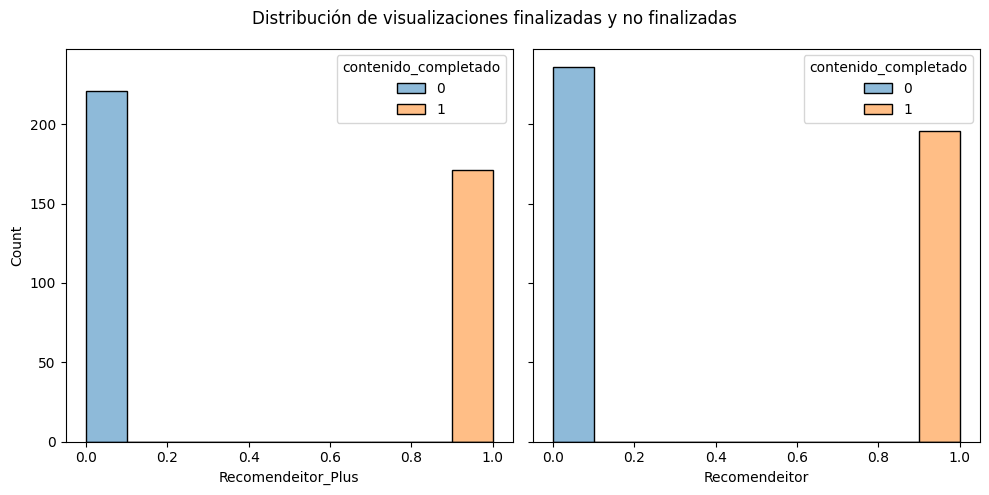

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
axes = axes.flat
sns.histplot(x="contenido_completado", hue="contenido_completado", data=df_usuarios[df_usuarios["recomendacion_usuario"]== "Recomendeitor_Plus"], ax= axes[0])
axes[0].set_xlabel("Recomendeitor_Plus")
sns.histplot(x="contenido_completado",hue="contenido_completado", data=df_usuarios[df_usuarios["recomendacion_usuario"]== "Recomendeitor"], ax= axes[1])
axes[1].set_xlabel("Recomendeitor")
fig.suptitle("Distribución de visualizaciones finalizadas y no finalizadas")
plt.tight_layout()


In [29]:

f.usar_kolmogorov(df_usuarios,"recomendacion_usuario" , "contenido_completado")

la metrica contenido_completado para Recomendeitor_Plus sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es False
la metrica contenido_completado para Recomendeitor sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es False


Numero views

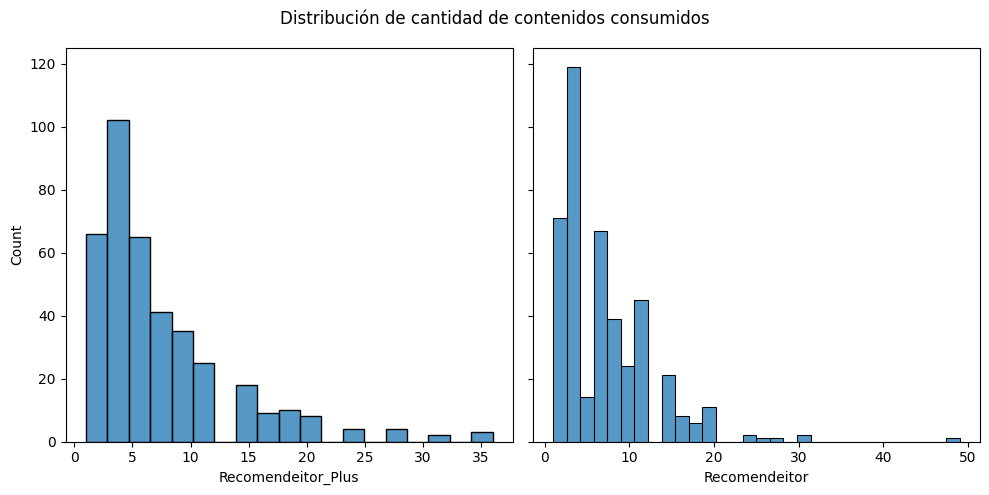

In [30]:
f.histograma_normal(df_usuarios,"numero_views", "Distribución de cantidad de contenidos consumidos", "Recomendeitor", "Recomendeitor_Plus")

In [31]:

f.usar_kolmogorov(df_usuarios,"recomendacion_usuario" , "numero_views")

la metrica numero_views para Recomendeitor_Plus sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es False
la metrica numero_views para Recomendeitor sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es False


Duracion contenido

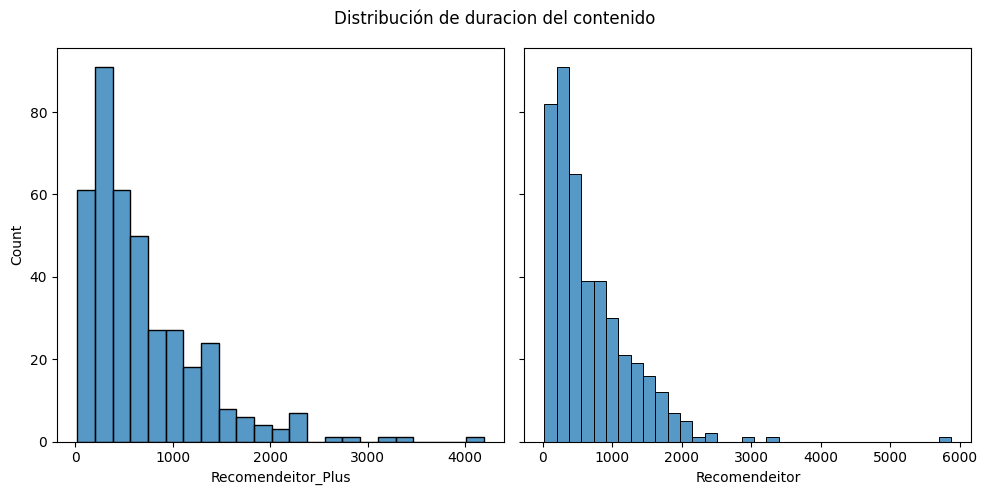

In [32]:
f.histograma_normal(df_usuarios,"duracion_contenido", "Distribución de duracion del contenido", "Recomendeitor", "Recomendeitor_Plus")

In [33]:

f.usar_kolmogorov(df_usuarios,"recomendacion_usuario" , "duracion_contenido")

la metrica duracion_contenido para Recomendeitor_Plus sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es False
la metrica duracion_contenido para Recomendeitor sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es False


Numero interacciones


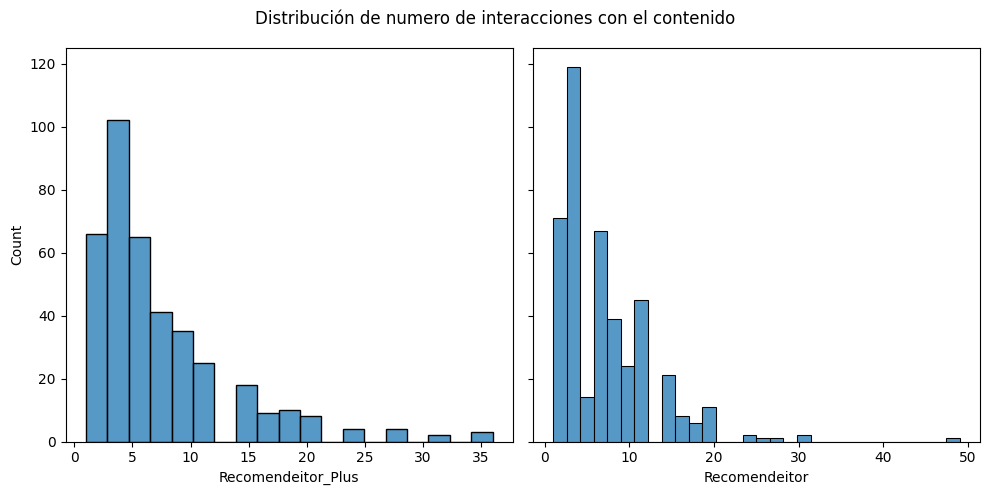

In [34]:
f.histograma_normal(df_usuarios,"numero_interaccion", "Distribución de numero de interacciones con el contenido", "Recomendeitor", "Recomendeitor_Plus")

In [35]:

f.usar_kolmogorov(df_usuarios,"recomendacion_usuario" , "numero_interaccion")

la metrica numero_interaccion para Recomendeitor_Plus sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es False
la metrica numero_interaccion para Recomendeitor sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es False


Tasa no repeticion

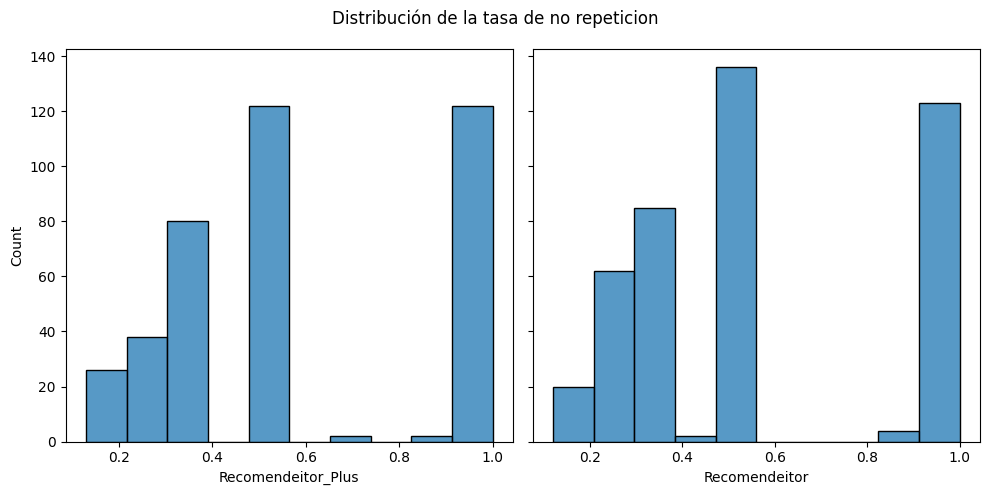

In [36]:
f.histograma_normal(df_usuarios,"tasa_no_repeticion", "Distribución de la tasa de no repeticion", "Recomendeitor", "Recomendeitor_Plus")

In [37]:

f.usar_kolmogorov(df_usuarios,"recomendacion_usuario" , "tasa_no_repeticion")

la metrica tasa_no_repeticion para Recomendeitor_Plus sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es False
la metrica tasa_no_repeticion para Recomendeitor sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es False


Numero tipos de contenido

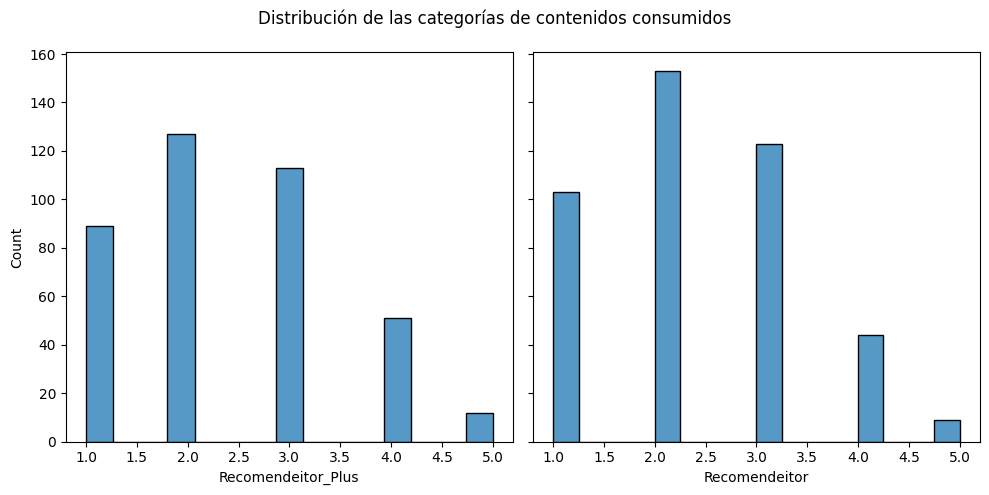

In [38]:
f.histograma_normal(df_usuarios,"numero_tipos_contenido", "Distribución de las categorías de contenidos consumidos", "Recomendeitor", "Recomendeitor_Plus")

In [39]:

f.usar_kolmogorov(df_usuarios,"recomendacion_usuario" , "numero_tipos_contenido")

la metrica numero_tipos_contenido para Recomendeitor_Plus sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es False
la metrica numero_tipos_contenido para Recomendeitor sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es False


Valoracion media

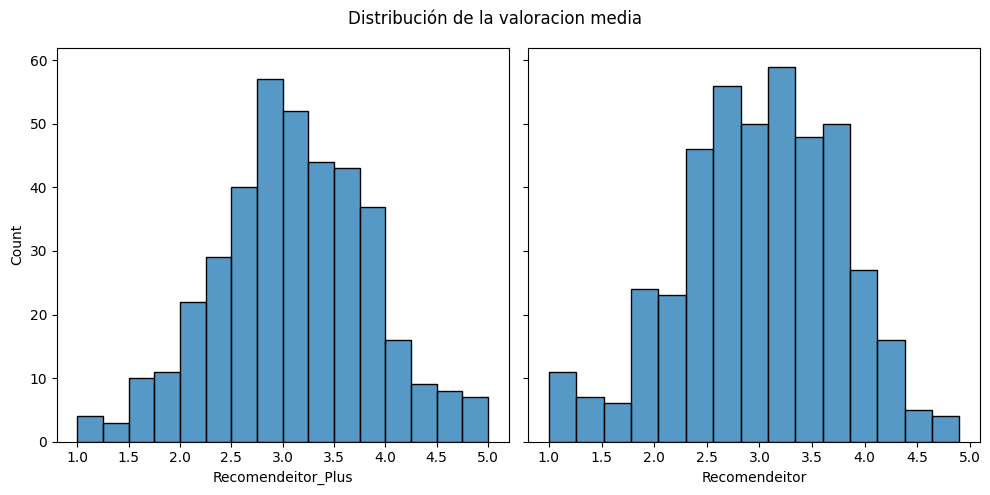

In [40]:
f.histograma_normal(df_usuarios,"valoracion_media", "Distribución de la valoracion media", "Recomendeitor", "Recomendeitor_Plus")

In [41]:

f.usar_kolmogorov(df_usuarios,"recomendacion_usuario" , "valoracion_media")

la metrica valoracion_media para Recomendeitor_Plus sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es True
la metrica valoracion_media para Recomendeitor sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es True


HEMOS PODIDO COMPROBAR COMO LA ÚNICA DISTRIBUCIÓN NORMAL ES LA DE LA VALORACION MEDIA CON LO QUE VAMOS A EVALUAR SU HOMOCEDASTICIDAD

In [42]:

f.usar_bartlett(df_usuarios, "recomendacion_usuario", "valoracion_media")

la metrica valoracion_media para Recomendeitor es homocedástica según el test de Bartlett. Esta afirmación es True con p-value de 0.6328224267237184


EFECTIVAMENTE TAMBIÉN ES HOMOCEDÁSTICA CON LO QUE DADO QUE LA INDEPENDENCIA YA SE DA POR HECHA AL SER USUARIOS INDEPENDIENTES, PASAMOS A USAR UNA T DE STUDENT 

In [43]:
f.usar_ttest(df_usuarios, "recomendacion_usuario", "valoracion_media")

Dado que el p_value es 0.07027134138285011, no hay evidencia suficiente para rechazar Ho con lo que no hay diferencia entre grupos de recomendacion_usuario para valoracion_media


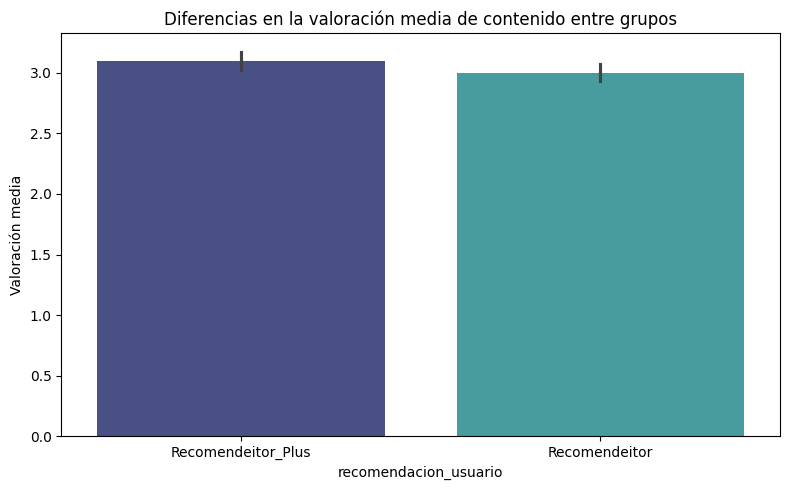

In [44]:
f.graph_diferencias_entre_grupos("recomendacion_usuario","valoracion_media",df_usuarios,"mako","Diferencias en la valoración media de contenido entre grupos","Valoración media")


Con esto concluimos que no hay diferencias en la valoración media de los contenidos entre el grupo de control (recomendeitor) y el de tratamiento (recomendeitor_Plus).

AHORA VAMOS A GESTIONAR TODAS LAS NO PARAMETRICAS EMPEZANDO POR UNA DE LAS MÁS PECULIARES

Contenido completado

In [45]:
f.usar_kolmogorov(df_usuarios,"recomendacion_usuario" , "contenido_completado")

la metrica contenido_completado para Recomendeitor_Plus sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es False
la metrica contenido_completado para Recomendeitor sigue una distribución normal según el test de Kolmogorov-Smirnov. Esta afirmación es False


In [46]:
#Uso un Z-Score porque la variable es no normal, no homocedástica y tiene 0 y 1.

df_test=df_usuarios[df_usuarios["recomendacion_usuario"]== "Recomendeitor_Plus"]
df_control=df_usuarios[df_usuarios["recomendacion_usuario"]== "Recomendeitor"]

tamanio_muestral=[df_control.shape[0], df_test.shape[0]]
convertidos= [df_control["contenido_completado"].sum(), df_test["contenido_completado"].sum()]
estadistico,p_value=proportions_ztest(convertidos, tamanio_muestral)  #El segundo es el p-value
if p_value >= 0.05:
    print(f"Dado que el p_value es {p_value}, no hay evidencia suficiente para rechazar Ho con lo que no hay diferencia entre grupos de recomendacion_usuario para el contenido_completado")
else:
     print(f"Dado que el p_value es {p_value}, hay evidencia suficiente para rechazar Ho con lo que hay diferencia entre grupos de recomendacion_usuario para el contenido_completado")

Dado que el p_value es 0.6141400619265027, no hay evidencia suficiente para rechazar Ho con lo que no hay diferencia entre grupos de recomendacion_usuario para el contenido_completado


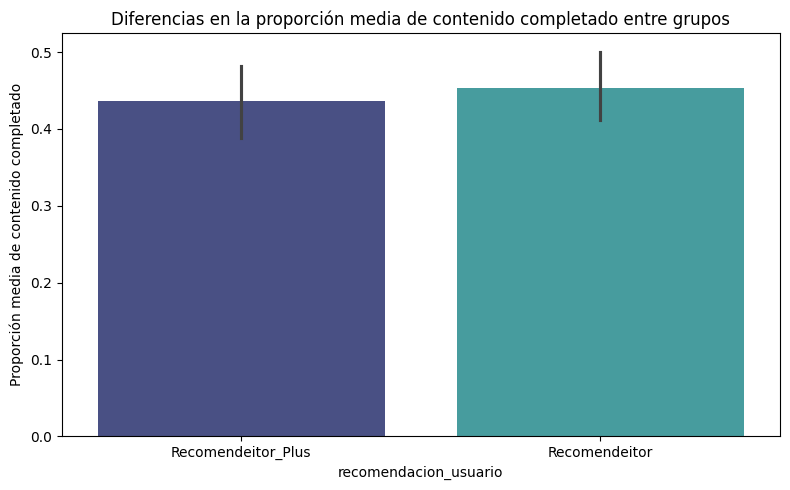

In [47]:
f.graph_diferencias_entre_grupos("recomendacion_usuario","contenido_completado",df_usuarios,"mako","Diferencias en la proporción media de contenido completado entre grupos","Proporción media de contenido completado")


Con esto concluimos que no hay diferencias en la proporción de contenido completado entre el grupo de control (recomendeitor) y el de tratamiento (recomendeitor_Plus).